In [11]:
# 1. 加载文档
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://zh.wikipedia.org/wiki/%E9%BB%91%E7%A5%9E%E8%AF%9D%EF%BC%9A%E6%82%9F%E7%A9%BA",)
)
docs = loader.load()

In [2]:
# 2. 文档分块
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [3]:
# 3. 设置嵌入模型
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-zh-v1.5",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

/mnt/external_disk/venv/20250203_LangChain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 4. 创建向量存储
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(all_splits)

['5eb00e34-6656-4dac-91c0-f25335d32219',
 '89a2c3b9-d7e7-42b6-8940-37ecab9aa16d',
 'e894828c-356f-4b26-a14b-fbc866fa7960',
 'e4ed714d-972e-4418-951a-7a07391587aa',
 '3f1edcf3-84f2-4e53-99e7-56cbd4625fad',
 '665b26f4-23a2-4b18-bbf5-ad0ec2b49d8b',
 '4b1dabaa-6583-4fe5-86d1-738c3d99fcb0',
 'a04569ab-9c07-4af3-a8f3-d5eea8b24d61',
 'af638a5a-bf07-454b-9a35-6f3895325beb',
 'ace8a5db-f96f-4fab-8df6-03992ce80080',
 '835653f8-af02-4861-9d2f-d7272f661ef6',
 'bd0cc933-0129-4f5b-accc-b9e2605f3aa2',
 '90b21e78-bbcf-4d5e-9e07-44ea48acbbdc',
 '1b8abc71-ae75-4900-838c-17ca52f3ec50',
 'e18caa96-772d-41db-a512-fca1014d97bd',
 'd80457a1-9007-4d14-b16e-6d410939395b',
 'b2816fa7-e383-442a-b257-5e4783500411',
 'e8ffc1b6-15da-4ec4-b478-a3b138979f75',
 '4cbdd7db-a1ec-445a-84b4-100d026663b1',
 'e614f9b6-5f48-4d3a-9381-f53b36d8ba9d',
 '94187d0b-5521-4930-bda5-9d6dc4560def',
 '18f47635-14d8-4efb-998a-5ff4e3f53ef1',
 'dd8a4907-e0bc-4089-9389-9a15b6482620',
 '82698303-c430-408a-bee3-fb70bf766e93',
 '2aa7fe08-8029-

In [5]:
# 5. 定义RAG提示词
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

/mnt/external_disk/venv/20250203_LangChain/lib/python3.10/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:
# 6. 定义应用状态
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [7]:
# 7. 定义检索步骤
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [8]:
# 8. 定义生成步骤
def generate(state: State):
    from langchain_openai import ChatOpenAI
    llm = ChatOpenAI(model="gpt-4")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

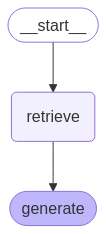

In [9]:
# 9. 构建和编译应用
from langgraph.graph import START, StateGraph
graph = (
    StateGraph(State)
    .add_sequence([retrieve, generate])
    .add_edge(START, "retrieve")
    .compile()
)

# 显示图结构
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:
# 10. 运行查询
question = "黑悟空有哪些游戏场景？"
response = graph.invoke({"question": question})
print(f"\n问题: {question}")
print(f"答案: {response['answer']}")


问题: 黑悟空有哪些游戏场景？
答案: 《黑神话：悟空》的游戏中，包含了很多中国文化和自然地标的元素，如大足石刻、小西天、南禅寺、铁佛寺、广胜寺和鹳雀楼等。游戏的章节设置也可能对应不同的游戏场景，包括“火照黑云”、“风起黄昏”、“夜生白露”、“曲度紫鸳”、“日落红尘”和“未竟”。游戏的进程大多是线性的，但也有较为宽阔的区域供玩家探索。
